# Activity Directions
The data and variables names are in different files; you will likely need them both. The goal here is to predict the age of the abalone using the other variables in the dataset because the traditional method for aging these organisms is boring and tedious.

There are two challenges (in my opinion):

1. You should try to build the best, bagging-based model (this includes random forests) to predict age.

2. The UC Irvine Machine Learning Repository classifies this dataset as a "classification" dataset, but age is stored as a numeric (albeit discrete-valued) variable. So, I think it could maybe be reasonable to treat this as a regression problem. It's up to you!

# Notes
- Large trees have high variance, but low bias so bagging is particularly useful for **decisions trees**.
- Good to use bagging with **Random Forests** if have one strong predictor and many other weaker ones as they address correlation in the trees.

# Process
## import data

In [2]:
from sklearn.preprocessing import LabelEncoder
from ucimlrepo import fetch_ucirepo 
  
# fetch dataset 
abalone = fetch_ucirepo(id=1) 
  
# data (as pandas dataframes) 
X = abalone.data.features.copy()
# # Converts 'M', 'F', 'I' to integers
le = LabelEncoder()
X['Sex'] = le.fit_transform(X['Sex'])

y = abalone.data.targets.values.ravel() 

X

,Sex,Length,Diameter,Height,Whole_weight,Shucked_weight,Viscera_weight,Shell_weight
0,2,0.455,0.365,0.095,0.5140,0.2245,0.1010,0.1500
1,2,0.350,0.265,0.090,0.2255,0.0995,0.0485,0.0700
2,0,0.530,0.420,0.135,0.6770,0.2565,0.1415,0.2100
3,2,0.440,0.365,0.125,0.5160,0.2155,0.1140,0.1550
4,1,0.330,0.255,0.080,0.2050,0.0895,0.0395,0.0550
...,...,...,...,...,...,...,...,...
4172,0,0.565,0.450,0.165,0.8870,0.3700,0.2390,0.2490
4173,2,0.590,0.440,0.135,0.9660,0.4390,0.2145,0.2605
4174,2,0.600,0.475,0.205,1.1760,0.5255,0.2875,0.3080
4175,0,0.625,0.485,0.150,1.0945,0.5310,0.2610,0.2960


## Bagging Decision Tree

In [4]:
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import BaggingRegressor
from sklearn.model_selection import cross_val_score, RepeatedKFold
from numpy import mean, std

# Define the model
bag = BaggingRegressor(estimator=DecisionTreeRegressor(), n_estimators=100, random_state=1)

# Evaluate
cv = RepeatedKFold(n_splits=10, n_repeats=3, random_state=1)
scores = cross_val_score(bag, X, y, scoring='neg_mean_absolute_error', cv=cv, n_jobs=-1)
scores2 = cross_val_score(bag, X, y, scoring='neg_mean_squared_error', cv=cv, n_jobs=-1)

# Metrics
print('MAE: %.3f (%.3f)' % (-mean(scores), std(scores)))
print('MSE: %.3f (%.3f)' % (-mean(scores2), std(scores2)))

MAE: 1.543 (0.075)
MSE: 4.743 (0.548)


## Random Forest

In [5]:
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import cross_val_score, RepeatedKFold
from numpy import mean, std

# Define the model
rf = RandomForestRegressor(n_estimators=100, random_state=1)

# Evaluate
cv = RepeatedKFold(n_splits=10, n_repeats=3, random_state=1)
scores = cross_val_score(rf, X, y, scoring='neg_mean_absolute_error', cv=cv, n_jobs=-1)
scores2 = cross_val_score(bag, X, y, scoring='neg_mean_squared_error', cv=cv, n_jobs=-1)

# Metrics
print('MAE: %.3f (%.3f)' % (-mean(scores), std(scores)))
print('MSE: %.3f (%.3f)' % (-mean(scores2), std(scores2)))

MAE: 1.544 (0.074)
MSE: 4.743 (0.548)


## Plotting Comparisons

In [6]:
from sklearn.model_selection import cross_val_score, RepeatedKFold
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import RandomForestRegressor, BaggingRegressor

cv = RepeatedKFold(n_splits=10, n_repeats=3, random_state=1)

models = {
    'Decision Tree': DecisionTreeRegressor(random_state=1),
    'Random Forest': RandomForestRegressor(n_estimators=100, random_state=1),
    'Bagging': BaggingRegressor(estimator=DecisionTreeRegressor(), n_estimators=100, random_state=1)
}

results = {}
for name, model in models.items():
    scores = -cross_val_score(model, X, y, scoring='neg_mean_absolute_error', cv=cv, n_jobs=-1)
    results[name] = scores


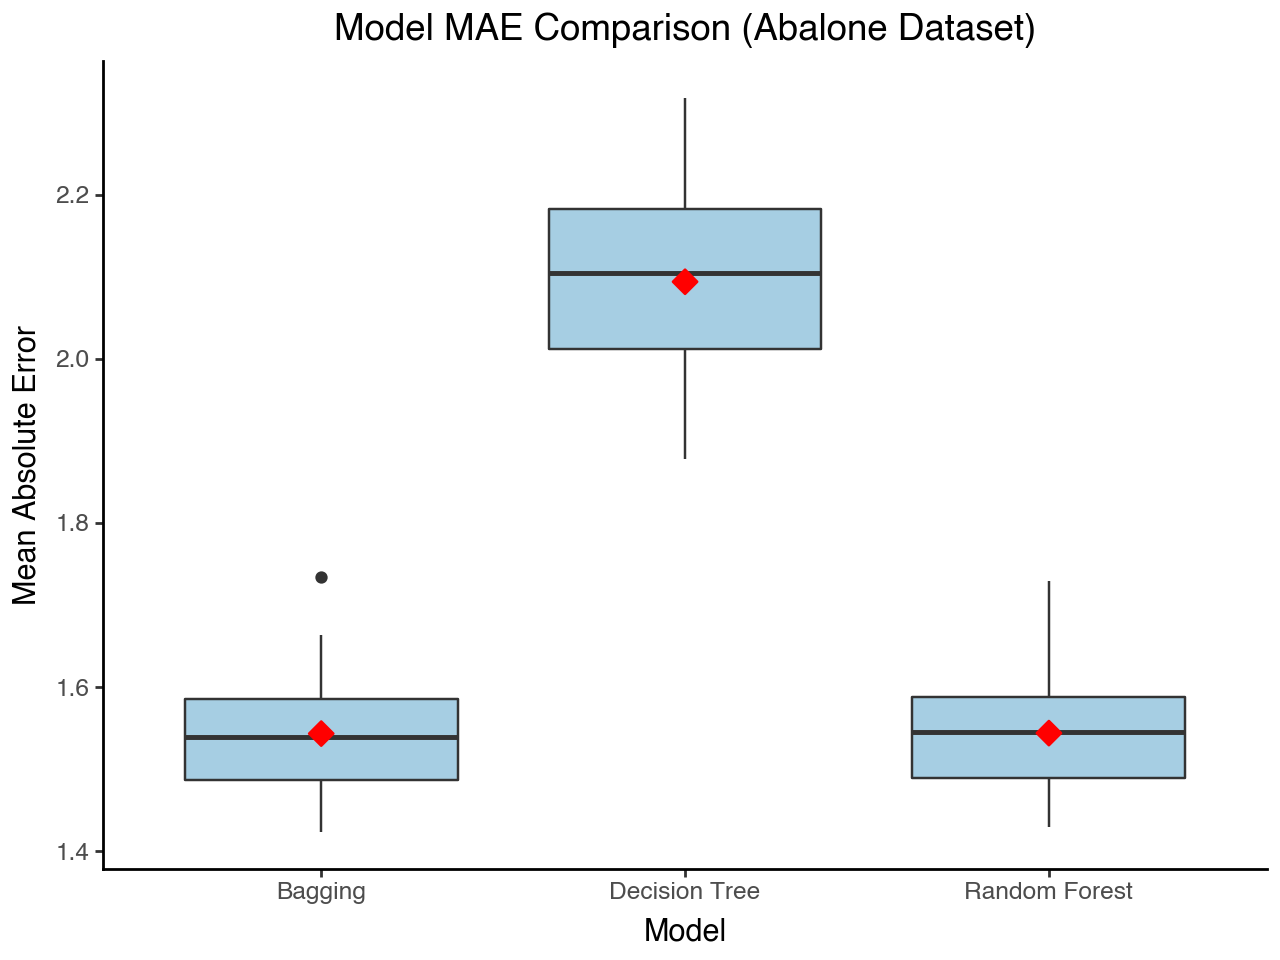

In [7]:
import pandas as pd
import numpy as np
from plotnine import *

# Prepare DataFrame for ggplot
df_results = pd.DataFrame({
    'Model': np.repeat(list(results.keys()), repeats=30),
    'MAE': np.concatenate(list(results.values()))
})

# Make the ggplot
p = (
    ggplot(df_results, aes(x='Model', y='MAE'))
    + geom_boxplot(fill='#a6cee3')
    + stat_summary(fun_y=np.mean, geom='point', shape='D', size=3, color='red')  # Show mean
    + labs(title='Model MAE Comparison (Abalone Dataset)', y='Mean Absolute Error', x='Model')
    + theme_classic()
)
p.show()
